# <a> Customer Lifetime Value prediction </a>

In [52]:
# Import standard libraries
from __future__ import division

# Import data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

# Import machine learning libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### How does the dataset look?

In [53]:
# reading the CSV data
df = pd.read_csv(filepath_or_buffer="./data/customer_segmentation.csv", encoding="cp1252") # Specify the encoding!

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### Check for NaN values and remove the ones we find

In [54]:
print(df[df.isnull().any(axis=1)])
df = df.dropna()

       InvoiceNo StockCode                      Description  Quantity  \
622       536414     22139                              NaN        56   
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
622     12/1/2010 11:52       0.00         NaN  United Kin

#### Convert InvoiceDate to pandas datetime/ Revenue field for easier date manipulation

In [55]:
# convert to pandas datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['UnitPrice'] * df['Quantity'] # This should be predicted!
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### Let's see which country the customers are from

In [56]:
df['Country'].value_counts().head(5)

Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: count, dtype: int64

#### As most customers are from the UK, going forward I will only be considering the UK customers

In [57]:
df = df.query("Country=='United Kingdom'").reset_index(drop=True)


#### For this project I am only going to be looking at the Customer LTV as a measure of Total Revenue - Total Cost
#### Therefore, I will remove the unneeded columns:

In [58]:
df = df.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'Country'])
df.head(2)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
0,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,20.34


#### Convert the CustomerID to an int64


In [59]:
df['CustomerID'] = df['CustomerID'].astype('int64')
df.head(2)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
0,6,2010-12-01 08:26:00,2.55,17850,15.30
1,6,2010-12-01 08:26:00,3.39,17850,20.34


## To calculate the Customer Lifetime Value, I will be using a popular business model
## RFM: Recency, Frequency, Monetary Value
### To make sense of the data I will be splitting our customers into 3 clusters:
#### -Low Value: Very low generators of revenue, perhaps even negative
#### -Medium Value: Moderate revenue generation
#### -High Value: High revenue generations, usually frequent users of our business

## <a> 1.Recency Cluster </a>

In [60]:
# Group by CustomerID and find the most recent purchase date
df_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()

# Calculate the most recent date in the dataset
most_recent_date = df['InvoiceDate'].max()

# Calculate recency score for each customer
df_recency['Recency'] = (most_recent_date - df_recency['InvoiceDate']).dt.days

# Drop the InvoiceDate column if not needed anymore
df_recency.drop(columns=['InvoiceDate'], inplace=True)

df_recency.head()

,CustomerID,Recency
0,12346,325
1,12747,1
2,12748,0
3,12749,3
4,12820,2


#### Here I have assigned a recency score to all my customers
### <a> 1.1 Elbow Method for Recency clusters </a>
#### Now we use the elbow method to check appropriate centroid nr

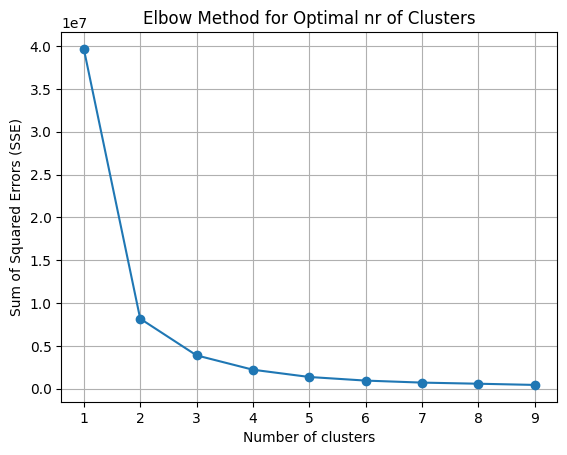

In [61]:


# Dictionary to store SSE values
sse = {}

# Extracting 'Recency' column from dataframe
temp_recency = df_recency[['Recency']]

# Loop through different cluster numbers
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(temp_recency)
    # Calculate SSE for each cluster configuration
    sse[k] = kmeans.inertia_

# Plotting
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')  # Adding marker for data points
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal nr of Clusters")
plt.grid(True)  # Adding grid for better readability
plt.show()


#### From the elbow method it looks like 2/3 clusters are optimal. I will be continuing with 3 clusters

In [62]:
kmeans = KMeans(n_clusters=3)
df_recency['RecencyCluster'] = kmeans.fit_predict(df_recency[['Recency']])
df_recency.head()

,CustomerID,Recency,RecencyCluster
0,12346,325,0
1,12747,1,1
2,12748,0,1
3,12749,3,1
4,12820,2,1


#### Let's see how each cluster looks

In [63]:
df_recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,548.0,295.689781,44.713495,227.0,259.0,287.5,329.0,373.0
1,2667.0,30.680540,25.376858,0.0,9.0,24.0,50.0,93.0
2,735.0,156.070748,38.464222,94.0,121.0,155.0,188.5,226.0


### <a> 1.2 Order the Recency clusters </a>

### Now I want my clusters to be ordered so that 0 is the best cluster and 2 is the worst

In [64]:
# Reorder the clusters
df_recency_summary = df_recency.groupby('RecencyCluster')['Recency'].mean().sort_values(ascending=True).reset_index()
cluster_mapping = {cluster: index for index, cluster in enumerate(df_recency_summary['RecencyCluster'])}
df_recency['RecencyCluster'] = df_recency['RecencyCluster'].map(cluster_mapping)

# Display the summary
df_recency.groupby('RecencyCluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2667.0,30.680540,25.376858,0.0,9.0,24.0,50.0,93.0
1,735.0,156.070748,38.464222,94.0,121.0,155.0,188.5,226.0
2,548.0,295.689781,44.713495,227.0,259.0,287.5,329.0,373.0


### Let's see the plot

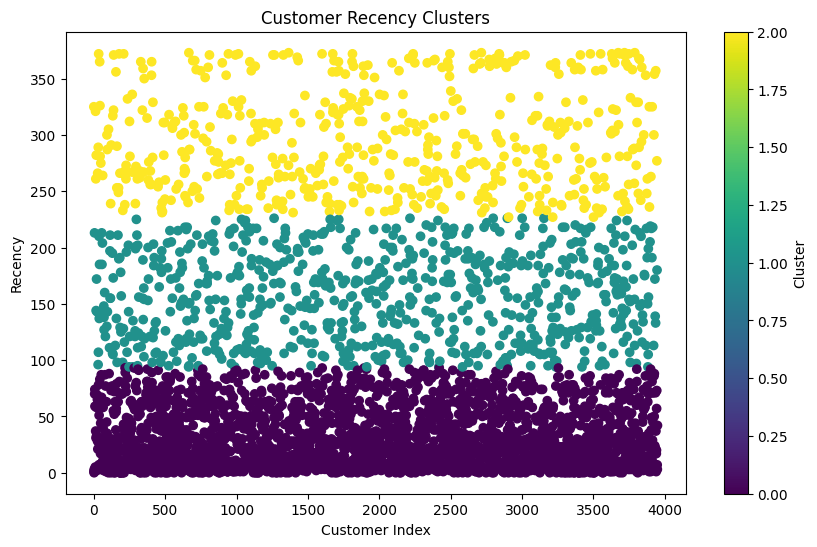

In [65]:

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.scatter(df_recency.index, df_recency['Recency'], c=df_recency['RecencyCluster'], cmap='viridis')
plt.title('Customer Recency Clusters')
plt.xlabel('Customer Index')
plt.ylabel('Recency')
plt.colorbar(label='Cluster')
plt.show()

### Spread of the recency clusters looks good

## <a> 2.Frequency Cluster </a>

#### To get the frequency value for each customer we can look at their number of orders

In [66]:
df_frequency = df.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency.head()

,CustomerID,Frequency
0,12346,2
1,12747,103
2,12748,4642
3,12749,231
4,12820,59


#### Customer 12748 seems to be in love with our service :)

### <a> 2.1 Elbow Method for Frequency clusters </a>

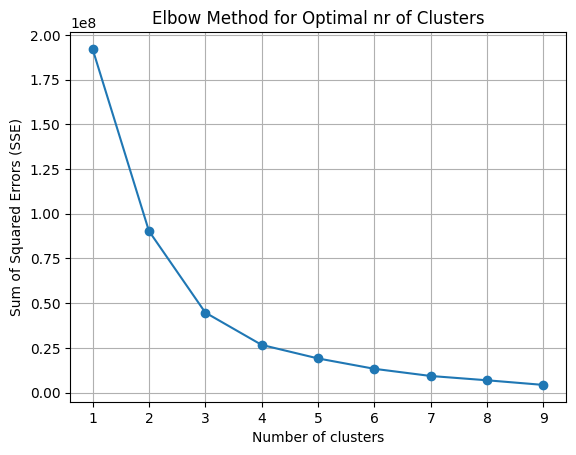

In [67]:

# Dictionary to store SSE values
sse = {}

# Extracting 'Recency' column from dataframe
temp_frequency = df_frequency[['Frequency']]

# Loop through different cluster numbers
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(temp_frequency)
    # Calculate SSE for each cluster configuration
    sse[k] = kmeans.inertia_

# Plotting
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')  # Adding marker for data points
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal nr of Clusters")
plt.grid(True)  # Adding grid for better readability
plt.show()

### It looks like the optimal number of clusters would be 3/4. I will be continuing with 3
### I will be applying the K-means algorithm:

In [68]:
# Applying k-Means
kmeans=KMeans(n_clusters=3)
df_frequency_copy = df_frequency.copy()
df_frequency_copy['FrequencyCluster']=kmeans.fit_predict(df_frequency_copy[['Frequency']])

df_frequency_copy.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3679.0,58.209296,58.196856,1.0,16.00,36.0,84.00,270.0
1,3.0,5917.666667,1805.062418,4642.0,4885.00,5128.0,6555.50,7983.0
2,268.0,484.973881,310.404803,271.0,314.75,392.0,516.75,2782.0


### I notice that FrequencyCluster nr 1 has only 3 customers

### Let's plot it to make sure

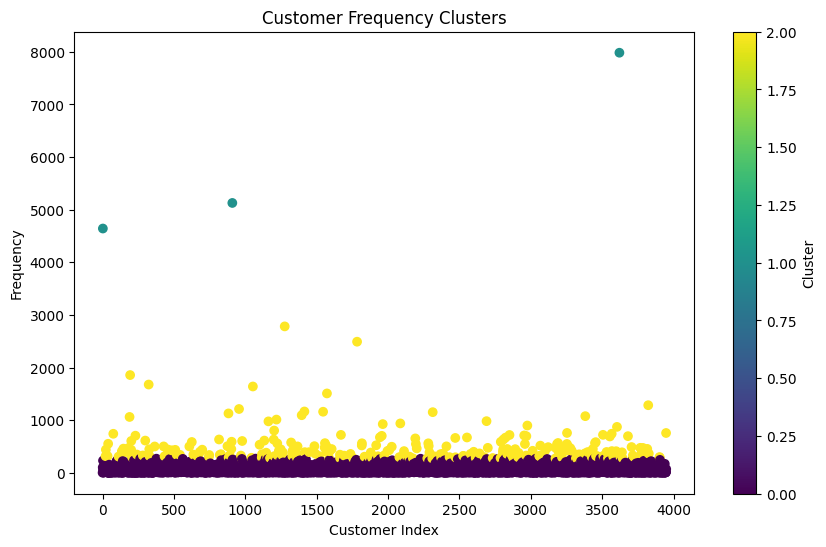

In [69]:

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.scatter(df_frequency_copy.index, df_frequency_copy['Frequency'], c=df_frequency_copy['FrequencyCluster'], cmap='viridis')
plt.title('Customer Frequency Clusters')
plt.xlabel('Customer Index')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()

### I can notice 3 outliers which I will remove

In [70]:
# Identify outliers
outliers = df_frequency[df_frequency['Frequency'] > 4000]  # Replace upper_bound with your desired threshold

# Remove outliers from the dataframe
df_frequency_cleaned = df_frequency[df_frequency['Frequency'] <= 4000]  # Replace upper_bound with your desired threshold

# Check the shape of the cleaned dataframe
print("Shape of original dataframe:", df_frequency.shape)
print("Shape of cleaned dataframe:", df_frequency_cleaned.shape)

Shape of original dataframe: (3950, 2)
Shape of cleaned dataframe: (3947, 2)


### Now run the KMeans algorithm again

In [71]:
# Applying k-Means
kmeans=KMeans(n_clusters=3)
df_frequency_cleaned['FrequencyCluster']=kmeans.fit_predict(df_frequency_cleaned[['Frequency']])

df_frequency_cleaned.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3500.0,49.687429,45.182138,1.0,15.0,33.0,73.0,191.0
1,425.0,332.541176,133.788498,192.0,228.0,291.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0


### <a> 2.2 Order the Frequency clusters </a>

In [72]:
# Reorder the clusters
df_frequency_summary = df_frequency_cleaned.groupby('FrequencyCluster')['Frequency'].mean().sort_values(ascending=True).reset_index()
cluster_mapping = {cluster: index for index, cluster in enumerate(df_frequency_summary['FrequencyCluster'])}
df_frequency_cleaned['FrequencyCluster'] = df_frequency_cleaned['FrequencyCluster'].map(cluster_mapping)

# Display the summary
df_frequency_cleaned.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3500.0,49.687429,45.182138,1.0,15.0,33.0,73.0,191.0
1,425.0,332.541176,133.788498,192.0,228.0,291.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0


### Let's plot it again to check the difference

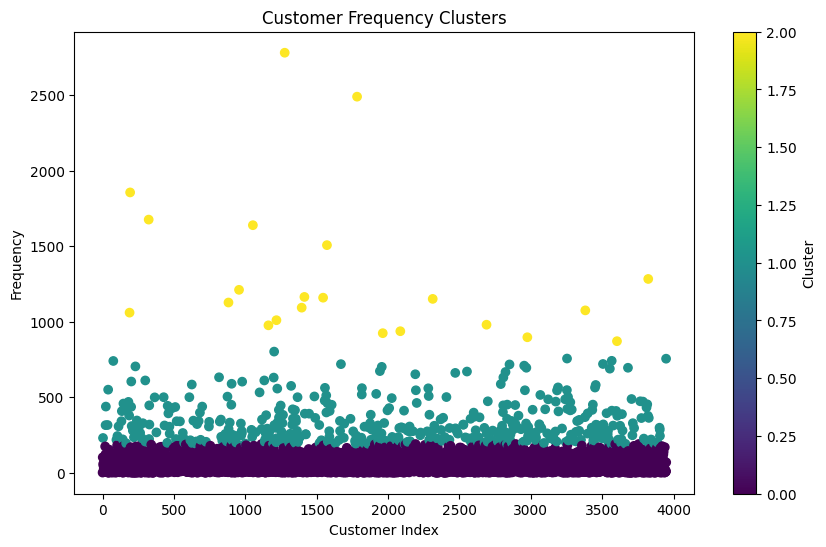

In [73]:

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.scatter(df_frequency_cleaned.index, df_frequency_cleaned['Frequency'], c=df_frequency_cleaned['FrequencyCluster'], cmap='viridis')
plt.title('Customer Frequency Clusters')
plt.xlabel('Customer Index')
plt.ylabel('Frequency')
plt.colorbar(label='Cluster')
plt.show()


## <a> 3. Monetary Value / Revenue Cluster </a>

#### To get the frequency value for each customer we can look at their number of orders

In [74]:
# Make a dataframe with CustomerID and Revenue
df_revenue = df.groupby('CustomerID').Revenue.sum().reset_index()
df_revenue.head()

,CustomerID,Revenue
0,12346,0.00
1,12747,4196.01
2,12748,29072.10
3,12749,3868.20
4,12820,942.34


### Do we have any customers with negative value?

In [75]:
negative_revenue_customers = df_revenue[df_revenue['Revenue'] < 0].astype('int64')

# Display the customers with negative revenue
negative_revenue_customers.head()

,CustomerID,Revenue
41,12870,-14
92,12943,-3
244,13154,-611
611,13672,-71
624,13693,-32


### Now let's apply the elbow method for the revenue dataframe

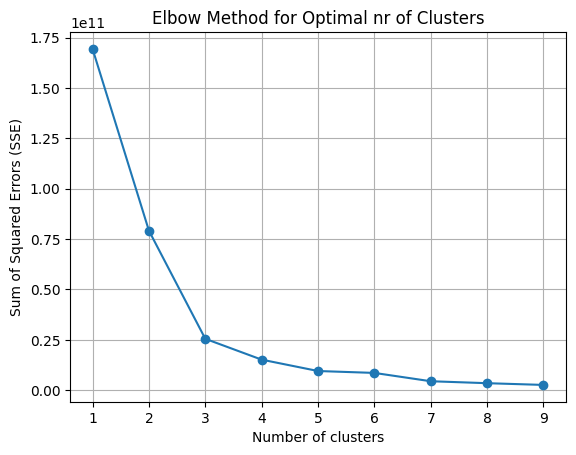

In [76]:

# Dictionary to store SSE values
sse = {}

# Extracting 'Revenue' column from dataframe
temp_revenue = df_revenue[['Revenue']]

# Loop through different cluster numbers
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(temp_revenue)
    # Calculate SSE for each cluster configuration
    sse[k] = kmeans.inertia_

# Plotting
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')  # Adding marker for data points
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal nr of Clusters")
plt.grid(True)  # Adding grid for better readability
plt.show()

### Here it also looks like the optimal number of centroids is 3/4, so I will be choosing 3 again

In [77]:
#apply clustering
kmeans = KMeans(n_clusters=3)
df_revenue_copy = df_revenue.copy()
df_revenue_copy['RevenueCluster'] = kmeans.fit_predict(df_revenue_copy[['Revenue']])


#show details of the dataframe
df_revenue_copy.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3921.0,1316.258790,2054.745461,-4287.63,280.52,621.66,1487.80,21535.90
1,2.0,221960.330000,48759.481478,187482.17,204721.25,221960.33,239199.41,256438.49
2,27.0,43070.445185,15939.249588,25748.35,28865.49,36351.42,53489.79,88125.38


### It's weird that my high value cluster only has 2 customers, they might be outliers in this problem

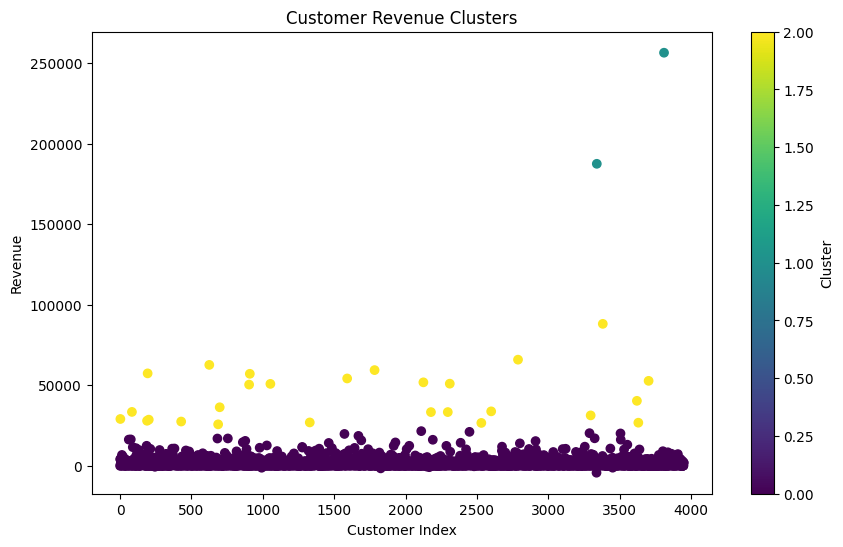

In [78]:

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.scatter(df_revenue_copy.index, df_revenue_copy['Revenue'], c=df_revenue_copy['RevenueCluster'], cmap='viridis')
plt.title('Customer Revenue Clusters')
plt.xlabel('Customer Index')
plt.ylabel('Revenue')
plt.colorbar(label='Cluster')
plt.show()

### From the graph above I would conclude that those two customers are indeed outliers, so I will remove them

In [79]:
# Identify outliers
outliers = df_revenue[df_revenue['Revenue'] > 160000]  # Replace upper_bound with your desired threshold

# Remove outliers from the dataframe
df_revenue_cleaned = df_revenue[df_revenue['Revenue'] <= 160000]  # Replace upper_bound with your desired threshold

# Check the shape of the cleaned dataframe
print("Shape of original dataframe:", df_revenue.shape)
print("Shape of cleaned dataframe:", df_revenue_cleaned.shape)

Shape of original dataframe: (3950, 2)
Shape of cleaned dataframe: (3948, 2)


### Now I will apply KMeans again

In [80]:
#apply clustering
kmeans = KMeans(n_clusters=3)
df_revenue_cleaned['RevenueCluster'] = kmeans.fit_predict(df_revenue_cleaned[['Revenue']])


#show details of the dataframe
df_revenue_cleaned.groupby('RevenueCluster')['Revenue'].describe()
df_revenue_cleaned.head()

,CustomerID,Revenue,RevenueCluster
0,12346,0.00,0
1,12747,4196.01,0
2,12748,29072.10,1
3,12749,3868.20,0
4,12820,942.34,0


### <a> 3.2. Order the Revenue clusters </a>

In [81]:
# Reorder the clusters
df_revenue_summary = df_revenue_cleaned.groupby('RevenueCluster')['Revenue'].mean().sort_values(ascending=True).reset_index()
cluster_mapping = {cluster: index for index, cluster in enumerate(df_revenue_summary['RevenueCluster'])}
df_revenue_cleaned['RevenueCluster'] = df_revenue_cleaned['RevenueCluster'].map(cluster_mapping)

# Display the summary
df_revenue_cleaned.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3688.0,908.182672,923.507907,-4287.63,263.3325,572.685,1258.675,4330.67
1,233.0,7775.420687,3638.011093,4345.50,5178.9600,6568.720,9167.820,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.4900,36351.420,53489.790,88125.38


### Plot it again to check the difference

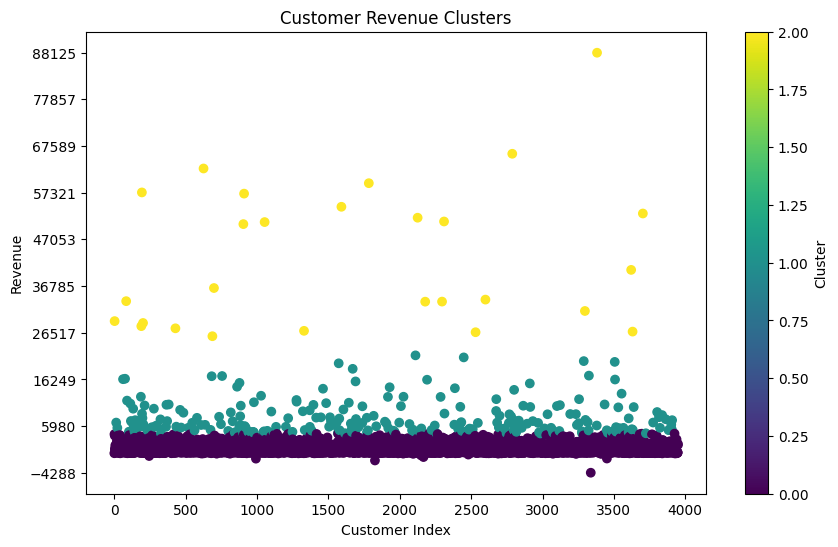

In [82]:

# Plot the dataframe
plt.figure(figsize=(10, 6))
plt.scatter(df_revenue_cleaned.index, df_revenue_cleaned['Revenue'], c=df_revenue_cleaned['RevenueCluster'], cmap='viridis')
plt.title('Customer Revenue Clusters')
plt.xlabel('Customer Index')
plt.ylabel('Revenue')
plt.colorbar(label='Cluster')
# Add yticks
plt.yticks(np.linspace(df_revenue_cleaned['Revenue'].min(), df_revenue_cleaned['Revenue'].max(), num=10))
plt.show()


## <a> 4. Overall Score Calculation </a>

### First I want to change my dataframe so that each customerID only appears once
### The new Revenue field will be the sum of all that customer's purchases

In [83]:
df_customer = df.groupby('CustomerID')['Revenue'].sum().reset_index()
df_customer.drop(columns=['Revenue'], inplace=True) 
df_customer.head()

,CustomerID
0,12346
1,12747
2,12748
3,12749
4,12820


### Now I want to add each user to his respective cluster

In [84]:
df_customer = pd.merge(df_customer, df_frequency_cleaned, on='CustomerID')
df_customer = pd.merge(df_customer, df_recency, on='CustomerID')
df_customer = pd.merge(df_customer, df_revenue_cleaned, on='CustomerID')

df_customer.head()

,CustomerID,Frequency,FrequencyCluster,Recency,RecencyCluster,Revenue,RevenueCluster
0,12346,2,0,325,2,0.00,0
1,12747,103,0,1,0,4196.01,0
2,12749,231,1,3,0,3868.20,0
3,12820,59,0,2,0,942.34,0
4,12821,6,0,213,1,92.72,0


## <a> Calculate an Overall Score for each user </a>
### I think that the most important metrics out of the Recency, Frequency and Revenue is Revenue
### So, when calculated the overall_score I will be using a weighed sum, where revenue is twice as important as frequency and recency


In [85]:

# Normalize Recency, Frequency, and Revenue
scaler = MinMaxScaler()
df_customer[['Recency', 'Frequency', 'Revenue']] = scaler.fit_transform(df_customer[['Recency', 'Frequency', 'Revenue']])

# Calculate Weighted Overall Score
df_customer['WeightedOverallScore'] = (
    0.25 * df_customer['RecencyCluster'] +
    0.25 * df_customer['FrequencyCluster'] +
    0.5 * df_customer['RevenueCluster']
)


# Group by WeightedOverallScore and calculate mean of Recency, Frequency, and Revenue
weighted_mean = df_customer.groupby('WeightedOverallScore')[['Recency','Frequency','Revenue']].mean()

df_customer.groupby('WeightedOverallScore')[['Recency','Frequency','Revenue']].mean()


,Recency,Frequency,Revenue
WeightedOverallScore,,,
0.00,0.091665,0.020836,0.056901
0.25,0.323504,0.037993,0.058086
0.50,0.702950,0.013981,0.058765
0.75,0.044779,0.131943,0.129983
1.00,0.098231,0.284358,0.224910
1.25,0.082079,0.142340,0.462384
1.50,0.003217,0.583963,0.660504


### Now we see that 0 is our worst score and 1.5 is our best

### Let's group our customers into low, mid and high value

In [86]:
df_customer['Segment'] = 'Low-Value'
df_customer.loc[df_customer['WeightedOverallScore']>0.3,'Segment'] = 'Mid-Value' 
df_customer.loc[df_customer['WeightedOverallScore']>1,'Segment'] = 'High-Value' 
df_customer.head()

,CustomerID,Frequency,FrequencyCluster,Recency,RecencyCluster,Revenue,RevenueCluster,WeightedOverallScore,Segment
0,12346,0.000360,0,0.871314,2,0.046396,0,0.50,Mid-Value
1,12747,0.036677,0,0.002681,0,0.091801,0,0.00,Low-Value
2,12749,0.082704,1,0.008043,0,0.088254,0,0.25,Low-Value
3,12820,0.020856,0,0.005362,0,0.056593,0,0.00,Low-Value
4,12821,0.001798,0,0.571046,1,0.047400,0,0.25,Low-Value


### Let's plot our customers based on Low/Mid/High Value

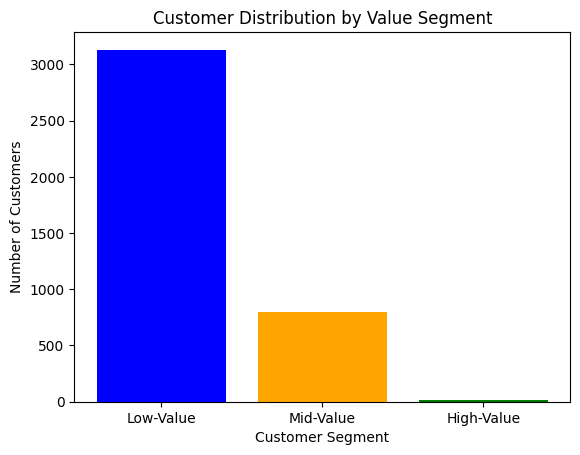

In [87]:
# Count the number of customers in each segment
segment_counts = df_customer['Segment'].value_counts()

# Plotting
plt.bar(segment_counts.index, segment_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution by Value Segment')
plt.show()


## <a> 5. Customer Lifetime Value </a>

### Let’s calculate 6 months LTV for each customer which we are going to use for training our model.

### Lifetime Value is the Total Gross Revenue, since we don't have a cost field


In [88]:
df['InvoiceDate'].describe()

count                           361878
mean     2011-07-10 23:48:12.301493760
min                2010-12-01 08:26:00
25%                2011-04-06 17:25:00
50%                2011-07-31 13:07:00
75%                2011-10-23 11:39:00
max                2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

#### We see that customers are active from 1 December 2010. Let us consider customers from March onwards (so that they are not new customers). 


In [89]:

# Filter for 6 months after June 2011
df_6m = df[(df['InvoiceDate'] >=  pd.to_datetime('2011-06')) & (df['InvoiceDate'] < (pd.to_datetime('2011-12') + pd.DateOffset(months=6)))].reset_index(drop=True)


In [90]:
#calculate revenue and create a new dataframe for it
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_customer_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_customer_6m.columns = ['CustomerID','m6_Revenue']
df_customer_6m.head()

,CustomerID,m6_Revenue
0,12747,2104.61
1,12748,19749.28
2,12749,3086.10
3,12820,771.88
4,12822,918.98


### Now I will merge 6 months dataframe and df_customer to see correlations between LTV and the feature set we have.

In [91]:
df_merge = pd.merge(df_customer, df_customer_6m, on='CustomerID', how='left') #Only people who are in the timeline of df_customer_6m
df_merge.dropna(inplace=True)
df_merge.head()

,CustomerID,Frequency,FrequencyCluster,Recency,RecencyCluster,Revenue,RevenueCluster,WeightedOverallScore,Segment,m6_Revenue
1,12747,0.036677,0,0.002681,0,0.091801,0,0.00,Low-Value,2104.61
2,12749,0.082704,1,0.008043,0,0.088254,0,0.25,Low-Value,3086.10
3,12820,0.020856,0,0.005362,0,0.056593,0,0.00,Low-Value,771.88
5,12822,0.016541,0,0.187668,0,0.056341,0,0.00,Low-Value,918.98
6,12823,0.001438,0,0.198391,0,0.065436,0,0.00,Low-Value,765.00


### Let's plot the 6 months revenue

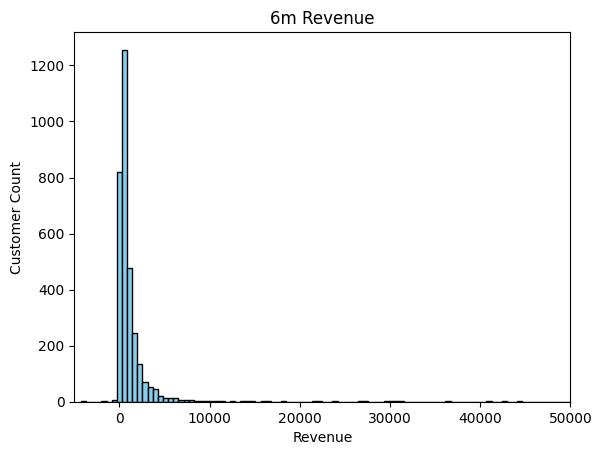

In [92]:

# Plotting the histogram
plt.hist(df_merge['m6_Revenue'], bins=100, color='skyblue', edgecolor='black')

# Adding title and labels
plt.title('6m Revenue')
plt.xlabel('Revenue')
plt.ylabel('Customer Count')
# max values end at 50000 and min values start at -5000
plt.xlim(-5000, 50000)
# Displaying the plot
plt.show()


Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):
* Low LTV
* Mid LTV
* High LTV

We are going to apply K-means clustering to decide segments and observe their characteristics


In [93]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
df_merge['LTVCluster'] = kmeans.fit_predict(df_merge[['m6_Revenue']])

df_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3021.0,725.150425,679.181568,-4287.63,244.4100,490.100,1014.1300,3192.54
1,16.0,31804.605625,9109.835224,21630.36,24023.8575,30001.915,37485.5475,52648.96
2,193.0,5667.148549,3000.012293,3204.16,3781.2600,4355.250,6355.4900,18052.00


### Now let's sort them

In [94]:
# Reorder the clusters
df_merge_summary = df_merge.groupby('LTVCluster')['m6_Revenue'].mean().sort_values(ascending=True).reset_index()
cluster_mapping = {cluster: index for index, cluster in enumerate(df_revenue_summary['RevenueCluster'])}
df_merge['LTVCluster'] = df_merge['LTVCluster'].map(cluster_mapping)
df_cluster = df_merge.copy()
# Display the summary
df_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3021.0,725.150425,679.181568,-4287.63,244.4100,490.100,1014.1300,3192.54
1,193.0,5667.148549,3000.012293,3204.16,3781.2600,4355.250,6355.4900,18052.00
2,16.0,31804.605625,9109.835224,21630.36,24023.8575,30001.915,37485.5475,52648.96


## <a> 6.Feature Engineering </a>


### Now we convert segment column into boolean values

In [95]:
#convert categorical columns to numerical
df_class = pd.get_dummies(df_cluster) #There is only one categorical variable segment
df_class.head()

,CustomerID,Frequency,FrequencyCluster,Recency,RecencyCluster,Revenue,RevenueCluster,WeightedOverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1,12747,0.036677,0,0.002681,0,0.091801,0,0.00,2104.61,0,False,True,False
2,12749,0.082704,1,0.008043,0,0.088254,0,0.25,3086.10,0,False,True,False
3,12820,0.020856,0,0.005362,0,0.056593,0,0.00,771.88,0,False,True,False
5,12822,0.016541,0,0.187668,0,0.056341,0,0.00,918.98,0,False,True,False
6,12823,0.001438,0,0.198391,0,0.065436,0,0.00,765.00,0,False,True,False


### Now we will calulate the correlation matrix to see the importance of each feature

In [96]:
#calculate and show correlations
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster              1.000000
RevenueCluster          0.807429
m6_Revenue              0.769459
Revenue                 0.747011
WeightedOverallScore    0.682207
Segment_Mid-Value       0.646744
Frequency               0.472560
Segment_High-Value      0.419768
FrequencyCluster        0.406003
CustomerID             -0.006832
RecencyCluster         -0.111769
Recency                -0.194876
Segment_Low-Value      -0.737907
Name: LTVCluster, dtype: float64

### Create X and y, X will be feature set and y is the label - LTV

In [97]:

X = df_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=56)
X_train.head()

,CustomerID,Frequency,FrequencyCluster,Recency,RecencyCluster,Revenue,RevenueCluster,WeightedOverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1904,15482,0.045307,0,0.040214,0,0.117476,1,0.50,False,False,True
2423,16181,0.003596,0,0.193029,0,0.049703,0,0.00,False,True,False
909,14099,0.090255,1,0.040214,0,0.079865,0,0.25,False,True,False
729,13849,0.035958,0,0.136729,0,0.063039,0,0.00,False,True,False
1133,14418,0.044229,0,0.008043,0,0.067359,0,0.00,False,True,False


## Machine Learning model for Customer Lifetime Value Prediction

### Our LTV Clusters are 3 types, high LTV, mid LTV and low LTV;

### Now I will use different models to interpret the data

### <a> 1. XGBoost Multiclassification Model </a>

In [98]:

ltv_xgb_model = xgb.XGBClassifier(max_depth=10, learning_rate=0.001,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
XGB_acc = accuracy_score(y_test, y_pred)
XGB_f1_score = f1_score(y_test, y_pred, average='macro')
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       299
           1       0.88      0.64      0.74        22
           2       1.00      1.00      1.00         2

    accuracy                           0.97       323
   macro avg       0.95      0.88      0.91       323
weighted avg       0.97      0.97      0.97       323



### <a> 2. Logistic regression model </a>

In [99]:

lr = LogisticRegression(random_state = 21, max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
logistic_regr_acc = accuracy_score(y_test, y_pred)
logistic_regr_macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", logistic_regr_acc)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.978328173374613

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.86      0.82      0.84        22
           2       0.67      1.00      0.80         2

    accuracy                           0.98       323
   macro avg       0.84      0.94      0.88       323
weighted avg       0.98      0.98      0.98       323



### <a> 3. Random Forest Classifier </a>

In [100]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

report = classification_report(y_test, y_pred)
random_forest_acc = accuracy_score(y_test, y_pred)
random_forest_macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", random_forest_acc)
print("\n -------------Classification Report-------------\n")
print(report)

Accuracy: 0.9752321981424149

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       299
           1       0.94      0.68      0.79        22
           2       1.00      1.00      1.00         2

    accuracy                           0.98       323
   macro avg       0.97      0.89      0.93       323
weighted avg       0.97      0.98      0.97       323



### <a> 4. Gradient Boosting Classifier </a>

In [101]:

gb = GradientBoostingClassifier()

# Train the model
gb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb.predict(X_test)

# Print the classification report and accuracy score
gradient_boosting_acc = accuracy_score(y_test, y_pred)
gradient_boosting_macro_f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy:', gradient_boosting_acc)
print(classification_report(y_test, y_pred))

Accuracy: 0.9752321981424149
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       299
           1       0.94      0.68      0.79        22
           2       1.00      1.00      1.00         2

    accuracy                           0.98       323
   macro avg       0.97      0.89      0.93       323
weighted avg       0.97      0.98      0.97       323



### <a> Now let's plot the results of the different models </a>

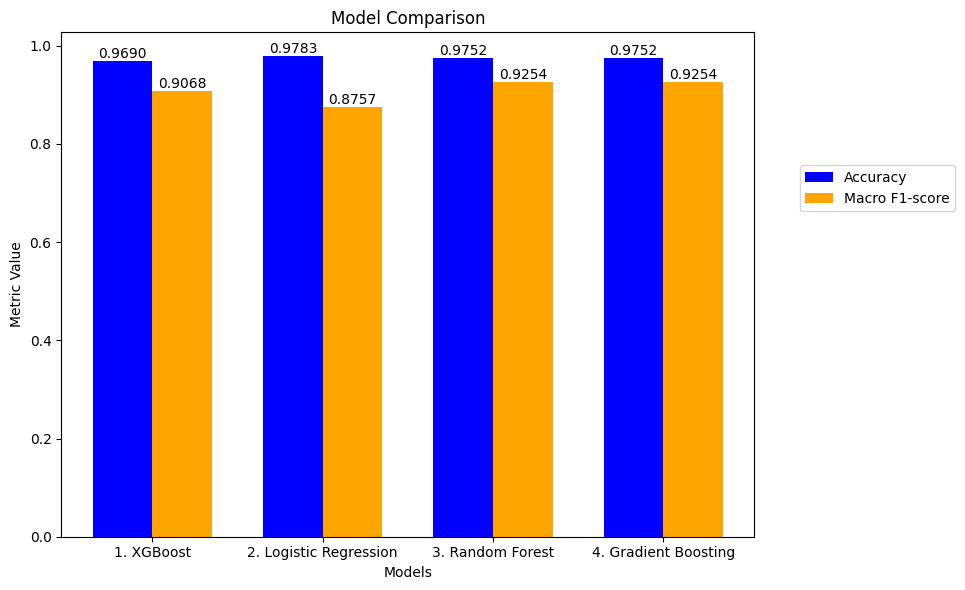

In [102]:

accuracies = [XGB_acc, logistic_regr_acc, random_forest_acc, gradient_boosting_acc]
macro_f1_scores = [XGB_f1_score, logistic_regr_macro_f1, random_forest_macro_f1, gradient_boosting_macro_f1]
models = ['1. XGBoost', '2. Logistic Regression', '3. Random Forest', '4. Gradient Boosting']

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Plotting bars for accuracy
bars_acc = plt.bar(index, accuracies, bar_width, label='Accuracy', color='blue')

# Plotting bars for macro F1-score
bars_f1 = plt.bar(index + bar_width, macro_f1_scores, bar_width, label='Macro F1-score', color='orange')

# Adding accuracy values on the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.4f}', ha='center', va='bottom')

# Adding macro F1-score values on the bars
for i, f1 in enumerate(macro_f1_scores):
    plt.text(i + bar_width, f1, f'{f1:.4f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Model Comparison')
plt.xticks(index + bar_width / 2, models)

# Adjusting legend position
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.75))

plt.tight_layout()
plt.show()

## <a> Conclusion </a>

### Accuracy and Macro F1 scores look good all around
### Another interesting thing I noticed is that by giving the overall score a spread of 60% for revenue, 30% for frequency and 10% for recency that the Macro F1-score grows from 0.89 to 0.91, while for the other models it makes no difference.
### Also, splitting the train-test ratio as 90% train 10% test seems to give better f1 scores for XGBoost, Random Forest and Gradient Boosting, while lowering the score for Logistic Regression
### For the 80-20 train-test ratio it seems like Logistic Regression is the best, but for the 90-10 train-test ratio Random Forest and Gradient Boosting give the best results
### So, I would conclude that the model would be useful for predicting CLV.